In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import time
import glob
import os

In [2]:
#testing with another earthquake from oso (magnitude 1.28)
#uw61855822	2022-07-22 12:51:02.070	4 km NE of Oso, Washington	48.300333	-121.885167	5.55	1
#file_list = glob.glob("/data/data5/Converted/whidbey_2022-07-22_12-51*h5")
#file_list = glob.glob("/data/data5/Converted/whidbey_2022-07-23_14-58*h5")#it should not have any earthquake here
#file_list


In [3]:
#parameters
chan_min = 100
chan_max = 300
channel_number = chan_max -chan_min
low_cut1 = 1
hi_cut1 = 10
fs = 100
samples_per_file = 60*fs


In [4]:
#data_file = h5py.File('/data/data5/Converted/whidbey_2022-07-23_14-58-00_UTC_013862.h5','r')
#this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
#this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
#attrs =     dict(data_file['Acquisition'].attrs)
#data_file.close()

In [5]:
file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08-07*")
#file_list
#download template oso earthquake data
template_file = h5py.File('/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5','r')

this_template = np.array(template_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
this_time1 = np.array(template_file['Acquisition/Raw[0]/RawDataTime'])
attrs1 =     dict(template_file['Acquisition'].attrs)
            
template_file.close()



b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
#data_filt = filtfilt(b,a,this_data,axis=0)
template_filt = filtfilt(b,a,this_template,axis=0)

template = template_filt[5000:5500,:]
template.shape
#data_filt.shape



def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr


def window_and_correlate(template,data):

    # define container
    all_corr = []

    # get some helpful values
    window_length = template.shape[0]
    num_windows = int(data.shape[0]/window_length)

    # iterate through time windows
    for i in range(num_windows):

        # pull out a time window of data
        start_index = i*window_length
        end_index = start_index + window_length
        window = data[start_index:end_index,:]

        # call cross correlation function
        corr = correlate(template,window)

        # save value
        all_corr.append(corr)

    # reshape output
    all_corr = np.stack(all_corr)

    return all_corr
corrs =  []
corrs = (window_and_correlate(template,template_filt))

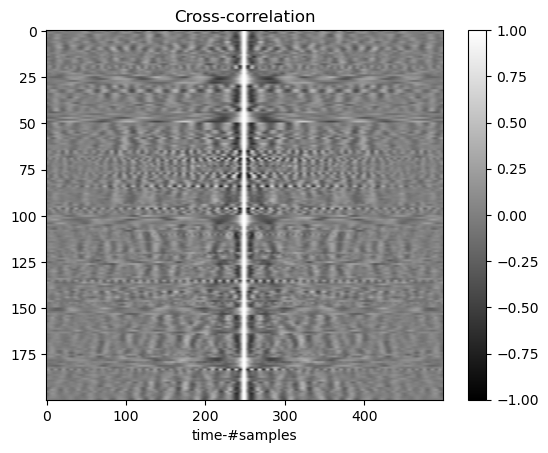

In [6]:

# list


plt.imshow(corrs[10, :, :].T, cmap='gray', aspect='auto', vmin=-1.0, vmax=1.0)

# Cross-correlation-plot
plt.colorbar()
plt.title('Cross-correlation')
plt.xlabel("time-#samples")
plt.show()


In [7]:
corrs2 = corrs.reshape((samples_per_file,channel_number))


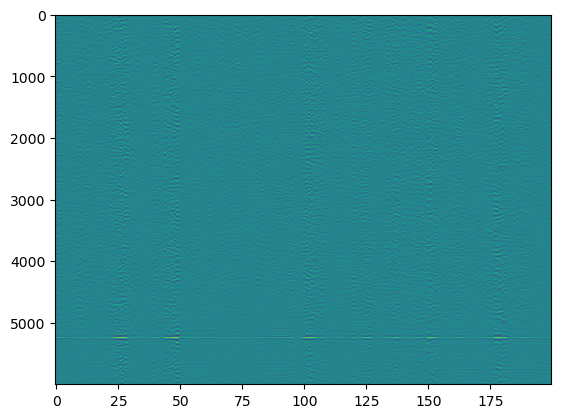

In [8]:
plt.imshow(corrs2, aspect= 'auto')
plt.show()

In [9]:
channel_number = chan_max -chan_min

corrs3 = np.sum(corrs2,axis=1)/channel_number
corrs3

array([-0.00169636, -0.00191552, -0.00202212, ..., -0.00344937,
       -0.01485973, -0.02414522])

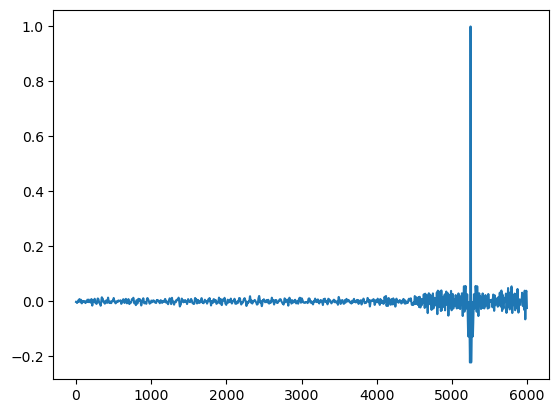

In [10]:
plt.plot(corrs3)
plt.show()

In [11]:
#testing 10 files


In [12]:
# Registra el tiempo de inicio
inicio_tiempo = time.perf_counter()
file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08-0*")

b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
corrs3_list = []
for i, file in enumerate(file_list):
    with h5py.File(file,"r") as f:
         # read the data and extract timing information
        raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
        timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime']) # time is microseconds since 1970-01-01
        data_filt = filtfilt(b,a,raw_data,axis=0)
        # check length of files
        win_start = i*samples_per_file
        win_end = (i+1)*samples_per_file
        
        if data_filt.shape[0] > samples_per_file:
            data_filt = data_filt[:samples_per_file, :]
        elif data_filt.shape[0] < samples_per_file:
            data_filt = np.pad(data_filt, ((0, samples_per_file - data_filt.shape[0]), (0, 0)), mode='constant')
        f.close()
        # Calculate correlations
        corrs = window_and_correlate(template, data_filt)
        corrs2 = corrs.reshape((samples_per_file, channel_number))
        corrs3 = np.sum(corrs2, axis=1) / channel_number
        corrs3_list.append(corrs3)
        
        # Save all the corrs3 arrays into separate .npy files

        
        output_folder = './npy_files_test'    
        for i, corrs3 in enumerate(corrs3_list):
            outfile_name = os.path.join(output_folder, f'corrs3_{i}.npy')
            np.save(outfile_name, corrs3)



                            






# Código que deseas medir
# Por ejemplo, aquí podrías tener una celda de código que quieras medir

# Registra el tiempo de finalización
fin_tiempo = time.perf_counter()

# Calcula el tiempo de ejecución
finaltime = fin_tiempo - inicio_tiempo

print(f"code took {finaltime} seconds.")

                            

code took 1.4885662132874131 seconds.


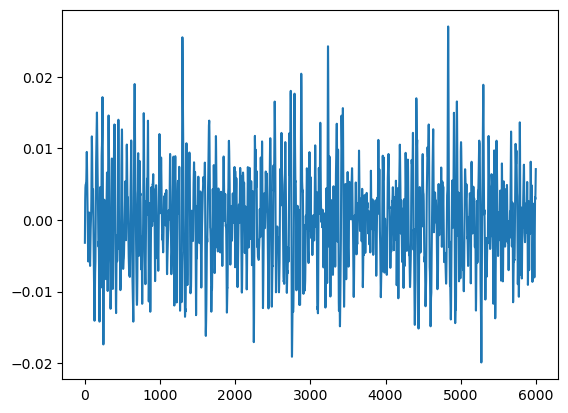

In [13]:
archivo_npy_a_abrir = "./npy_files_test/corrs3_9.npy"

# load files with load
datos = np.load(archivo_npy_a_abrir)

#ploooot
datos.shape
plt.plot(datos)